# Experimental: Self-Supervised Learning

Our goal will be to teach a neural network to learn how to solve an airfoil optimization problem. This notebook uses a surrogate model of the actual CFD solver for development purposes.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import pathlib
import jenn
from scipy.stats import qmc
from jenn.core.cost import Loss

In [3]:
SEED = 123

## Parabolic Test Function

_First, we will test that the process is working for a parabolic test function._

### Training Data

In [4]:
m = 100
lb = -5
ub = 5
x_train = x1 = np.linspace(lb, ub, m).reshape((1, -1)) 
x2 = -1/2 * x1  # optimum given x1
y_train = x1 ** 2 + x2 ** 2 + x1 * x2

### Custom Loss

In [5]:
class CustomLoss(Loss): 
    """Parabola."""

    def denormalize(self, Y_pred: np.ndarray) -> np.ndarray:
        x_norm = self.X 
        y_norm = Y_pred 
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y
        
    def evaluate(self, Y_pred: np.ndarray) -> np.ndarray:
        x, y = self.denormalize(Y_pred)
        return x ** 2 + y ** 2 + x * y

    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        return 2 * y + x

### Training

Training can be done in one line of code. 

In [6]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0], 7, 7, y_train.shape[0]],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-1,
    lambd=1e-4, 
    beta1=0.8,
    beta2=0.7,
    max_iter=500,
    is_normalize=False,
    is_backtracking=True,
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CustomLoss,
    N1_max=25,
    N2_max=25, 
)

CPU times: user 154 ms, sys: 1.06 ms, total: 155 ms
Wall time: 155 ms


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

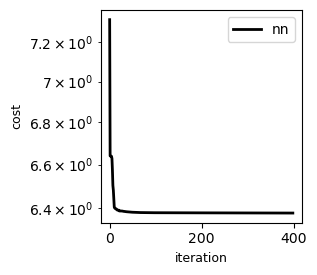

In [7]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

#### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

In [8]:
x1 = x_train
x2 = nn.predict(x_train) 
y_pred = x1 ** 2 + x2 ** 2 + x1 * x2

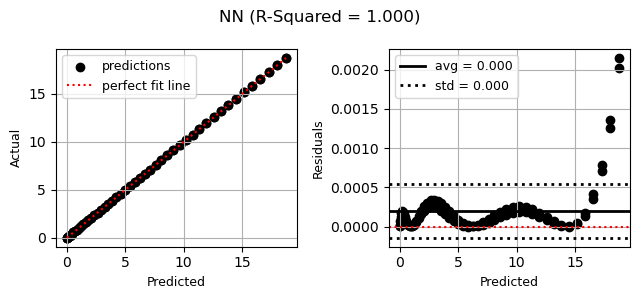

In [9]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train, 
    y_pred=y_pred,
    title="NN"
)

## Airfoil Shape Optimization 

We now test SSL on a small yet representative airfoil shape optimization problem. Given some desired flight condition, we seek to use SSL in order to predict the optimal airfoil shape. 

### Training Data

In [10]:
df = pd.read_csv("DATABASE_OF_OPTIMIZED_SHAPEVARS.csv", index_col=0)

In [11]:
x_labels = ["M", "CL"]
y_labels = [f"X{i}" for i in range(14)]

In [12]:
x_train = df[x_labels].values.T
y_train = df[y_labels].values.T

In [13]:
n_x = len(x_labels)
n_y = len(y_labels)

### SSL Data

In [14]:
def fullfact2(levels=(10, 10)): 
    """Generate full factorial for two variables."""
    x1 = np.linspace(0, 1, levels[0])
    x2 = np.linspace(0, 1, levels[1])
    return np.array([[x1[i], x2[j]] for i in range(levels[0]) for j in range(levels[1])])

In [15]:
xmin = x_train.min(axis=1, keepdims=True)
xmax = x_train.max(axis=1, keepdims=True)

In [16]:
sample = np.concat([
    fullfact2(levels=(10, 10)), 
    # qmc.LatinHypercube(d=2, optimization="random-cd").random(41)
], axis=0)

In [17]:
m = sample.shape[0]

In [18]:
x_ssl = xmin + (xmax - xmin) * sample.T
y_ssl = np.zeros((n_y, m))

<Axes: xlabel='M', ylabel='CL'>

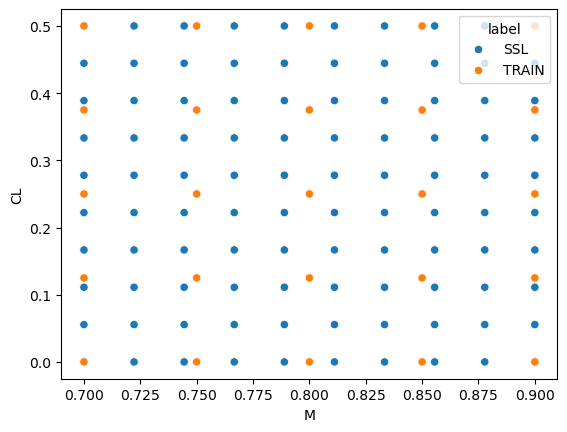

In [19]:
sns.scatterplot(
    data=pd.DataFrame(
        {
            "M": np.concat([x_ssl[0], x_train[0]]),
            "CL": np.concat([x_ssl[1], x_train[1]]),
            "label": ["SSL"] * x_ssl.shape[-1] + ["TRAIN"] * x_train.shape[-1]
        }
    ), 
    x="M", 
    y="CL", 
    hue="label"
)

### CFD Function Call

In [20]:
surrogate_model = jenn.model.NeuralNet(
        layer_sizes=[16, [16] * 5, 1]
    ).load('gnn_parameters_7500.json') 

In [21]:
def cfd_model(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]: 
    """Evaluate CFD surrogate model. 

    :param x: array of shape (2, m) containing [M, CL]
    :param y: array of shape (14, m) containing shape variables 
    :returns: CD, dCDdy 
    """
    CD, CD_partials = surrogate_model.evaluate(np.concatenate([x, y], axis=0)) 
    return 1e0 *CD, 1e0 *CD_partials[:, 2:, :]

## Custom Loss

_We'll use a surrogate of the model for illustration but, in practice, one would use the actual CFD model._

In [22]:
def transform(cost: np.ndarray, partials: np.ndarray, multiplier: float = 1e4):  
    value = np.log(1 + multiplier * cost)
    partials = multiplier * partials / (1 + multiplier * cost)
    return value, partials

In [23]:
class CFDLoss(Loss): 
    """Minimize drag."""

    def denormalize(self, x_norm: np.ndarray, y_norm: np.ndarray) -> np.ndarray:
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y

    def normalize(self, partials: np.ndarray) -> np.ndarray:
        return partials * self.data.y_scale

    def exterior_penalty(self, y: np.ndarray, lb: float = -0.01, ub: float = 0.01, r_p: float = 1e6): 
        """Use exterior penalty to account for bound constraints."""
        n, m = y.shape 
        ymax = np.maximum(0, (y - ub)) / (ub - lb)
        ymin = np.minimum(0, (y - lb)) / (ub - lb)
        value = r_p * np.sum((ymin ** 2 + ymax ** 2), axis=0, keepdims=True)
        partials = 2 * r_p * (ymin + ymax) / (ub - lb)
        return value, partials.reshape((1, n, m))
        
    def evaluate(self, Y_pred: np.ndarray, is_verbose: bool = False) -> np.ndarray:
        """Compute drag for each airfoil shape."""
        x, y = self.denormalize(self.X, Y_pred)
        drag, drag_partials = cfd_model(x, y) 
        loss, loss_partials = transform(drag, drag_partials)
        penalty, penalty_partials = self.exterior_penalty(y)
        
        if is_verbose: 
            print()
            for i in range(x.shape[-1]): 
                print(f"M = {x[0, i]: 6.4f} | Cl = {x[1, i]: 6.4f} | Cd = {drag[0, i]: 6.4f} | Loss = {loss[0, i]: 6.6f} | penalty = {penalty[0, i]: 6.4f} | CASE: {i}")
            print()
            
        return loss + penalty
    
    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(self.X, Y_pred)
        drag, drag_partials = cfd_model(x, y) 
        loss, loss_partials = transform(drag, drag_partials)
        penalty, penalty_partials = self.exterior_penalty(y)
        partials = loss_partials + penalty_partials
        return self.normalize(partials)

# Initialization

Initialize neural net parameters with sample seed points: 

In [24]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [28] * 3 + [y_train.shape[0]]
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-2,
    lambd=1e-2,
    beta1=0.9,
    beta2=0.99,
    max_count=10,
    max_iter=1500,
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    epsilon_absolute=1e-6,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-6,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=100,
    N2_max=100,
    tol=1e-6
)

CPU times: user 2.99 s, sys: 11.1 ms, total: 3 s
Wall time: 3.01 s


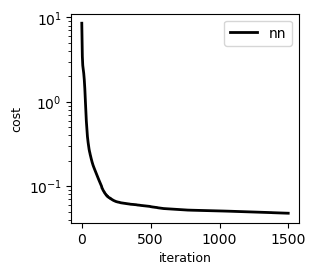

In [25]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

_Check_: 

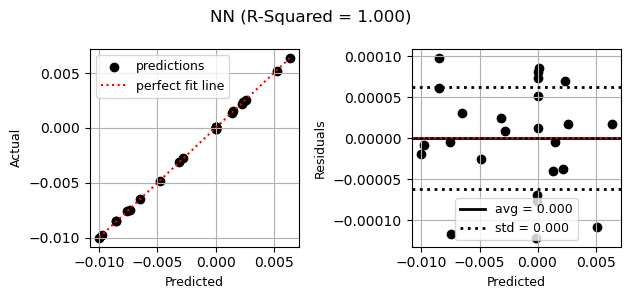

In [26]:
i = 10
jenn.utils.plot.goodness_of_fit(
    y_true=y_train[i],
    y_pred=nn.predict(x_train)[i],
    title="NN", 
    percent_residuals=False
)

## Training

In [27]:
n_x, m = x_train.shape 
n_y, _ = y_train.shape  # y_train not needed in SSL

In [34]:
%%time
nn = nn.fit(
    x=x_ssl, 
    y=y_ssl, 
    alpha=1e-4,
    lambd=1e-1,
    beta1=0.9,
    beta2=0.99,
    max_count=10,
    max_iter=1000,
    is_warmstart=True, 
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CFDLoss, 
    epsilon_absolute=1e-6,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-6,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=100,
    N2_max=100,
    tol=1e-6
)

CPU times: user 670 ms, sys: 54.2 ms, total: 724 ms
Wall time: 723 ms


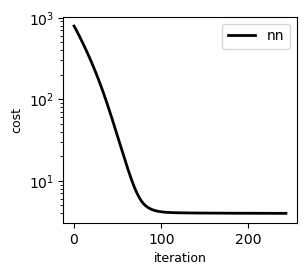

In [35]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

In [36]:
nn.predict(np.array([[0.7, 0.8, 0.9], [0.25, 0.5, 0.3]]))

array([[-2.93957183e-04, -1.17338283e-03, -9.08665356e-03],
       [-1.82792770e-04, -2.18892058e-03, -9.48056764e-03],
       [-2.11175396e-04, -2.82531487e-03, -9.45567924e-03],
       [-5.57734849e-05, -2.36026222e-03, -9.88579572e-03],
       [ 2.73968289e-04, -1.60533059e-03, -6.75122347e-03],
       [-9.98188804e-04, -4.21583093e-03, -1.12812724e-03],
       [-9.60635818e-04, -5.24867068e-03, -1.56388818e-03],
       [ 1.09122678e-05, -1.33817131e-03, -9.88104894e-03],
       [-3.29850620e-05, -9.39066793e-03, -9.59974848e-03],
       [-3.27241749e-04, -6.68500359e-03, -9.54878079e-03],
       [-8.10141531e-06,  2.02437696e-03, -7.84257785e-03],
       [ 1.94718497e-03,  8.94154234e-03, -6.60558690e-03],
       [-4.11525181e-04,  5.37542583e-03, -5.81727483e-03],
       [ 5.77936774e-04,  2.42623566e-03,  5.00324232e-03]])

### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

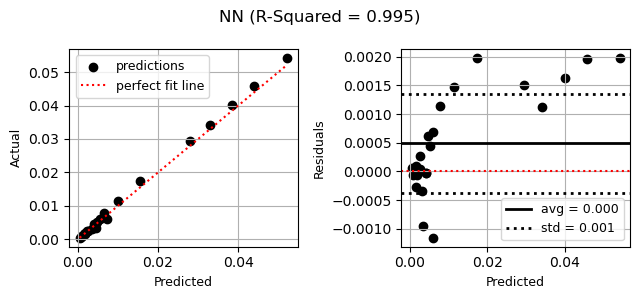

In [37]:
jenn.utils.plot.goodness_of_fit(
    y_true=cfd_model(x=x_train, y=y_train)[0],
    y_pred=cfd_model(x=x_train, y=nn.predict(x_train))[0],
    title="NN", 
    percent_residuals=False
)

_Performance of SSL vs. test data_

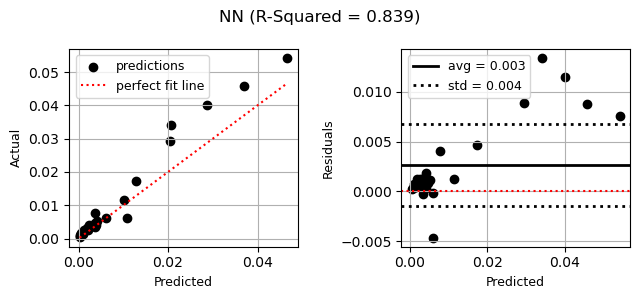

In [38]:
jenn.utils.plot.goodness_of_fit(
    y_true=1e0 * df["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=nn.predict(x_train))[0],
    title="NN", 
    percent_residuals=False
)

_Performance of the "CFD surrogate model" vs. test data for reference_

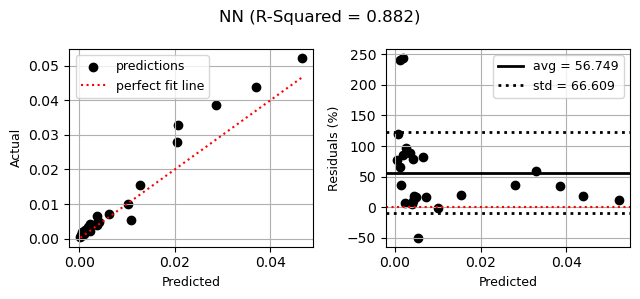

In [43]:
jenn.utils.plot.goodness_of_fit(
    y_true=1e0 * df["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=y_train)[0],
    title="NN", 
    percent_residuals=True
)